In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import powerlaw
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde

In [95]:
# Load the lora_download_count.pkl file
with open('lora_download_count.pkl', 'rb') as f:
    lora_download_count = pickle.load(f)

[(0, 361000), (1, 287364), (2, 235502), (3, 208238), (4, 192330), (5, 167267), (6, 164047), (7, 157632), (8, 157448), (9, 154270)]


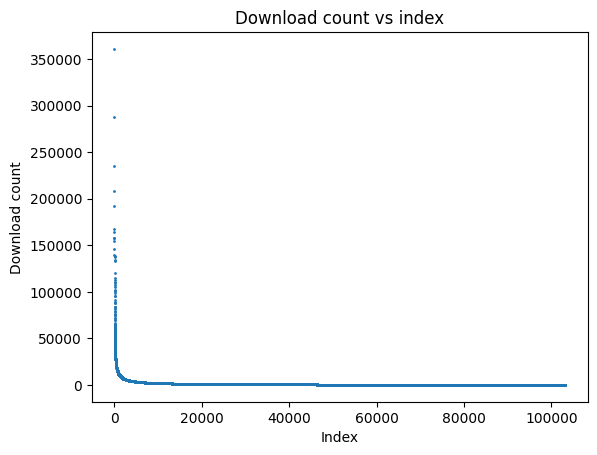

In [97]:
# Make a list of (index, download_count) tuples
data = [(i, count) for i, count in enumerate(lora_download_count)]
print(data[:10])

# Plot the data
plt.figure()
plt.scatter(*zip(*data), s=1)
plt.xlabel('Index')
plt.ylabel('Download count')
plt.title('Download count vs index')
plt.show()

Fitted power law: y = exp(17.70)x^-1.10


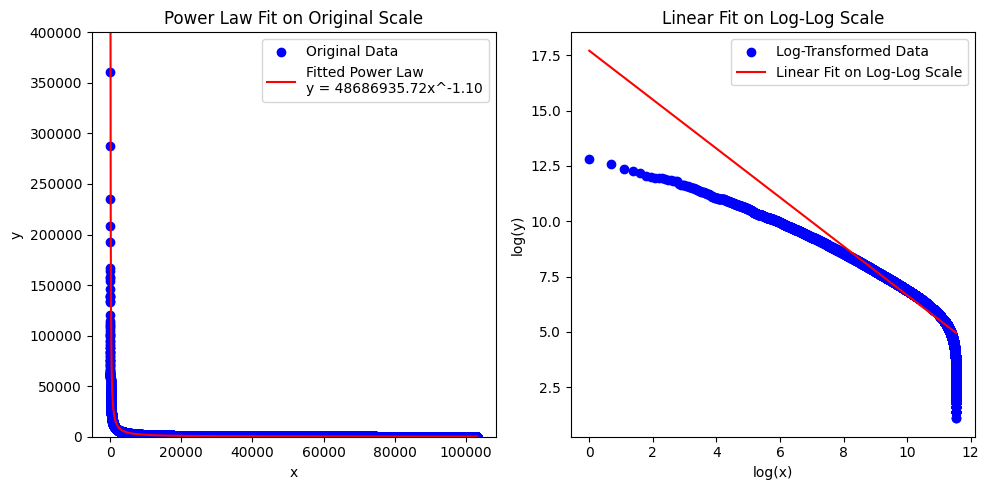

In [100]:
x = np.array([d[0] for d in data]) + 1  # Add 1 to avoid log(0)
y = np.array([d[1] for d in data])

# Transform data
log_x = np.log(x)
log_y = np.log(y)

# Fit linear regression to transformed data
coefficients = np.polyfit(log_x, log_y, 1)  # Linear fit
k = coefficients[0]  # This is the power-law exponent
b = coefficients[1]  # This is the log(a)
print(f'Fitted power law: y = exp({b:.2f})x^{k:.2f}')

# Compute fitted y values
fitted_log_y = np.poly1d(coefficients)(log_x)
fitted_y = np.exp(fitted_log_y)  # Convert back by exponentiating

# Plotting the results
plt.figure(figsize=(10, 5))

# Original Data
plt.subplot(1, 2, 1)
plt.scatter(x, y, color='blue', label='Original Data')
plt.plot(x, fitted_y, color='red', label=f'Fitted Power Law\ny = {np.exp(b):.2f}x^{k:.2f}')
plt.ylim(0, 400000)


plt.xlabel('x')
plt.ylabel('y')
plt.title('Power Law Fit on Original Scale')
plt.legend()

# Log-Log Plot
plt.subplot(1, 2, 2)
plt.scatter(log_x, log_y, color='blue', label='Log-Transformed Data')
plt.plot(log_x, fitted_log_y, color='red', label='Linear Fit on Log-Log Scale')
plt.xlabel('log(x)')
plt.ylabel('log(y)')
plt.title('Linear Fit on Log-Log Scale')
plt.legend()

plt.tight_layout()
plt.show()


In [103]:
# Calculate predicted y values using the power-law model
y_pred = np.exp(b) * x**k

# Calculate performance metrics
mse = np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y - y_pred))

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 33269061112.108986
Root Mean Squared Error (RMSE): 182398.08417883393
Mean Absolute Error (MAE): 2555.664691110258


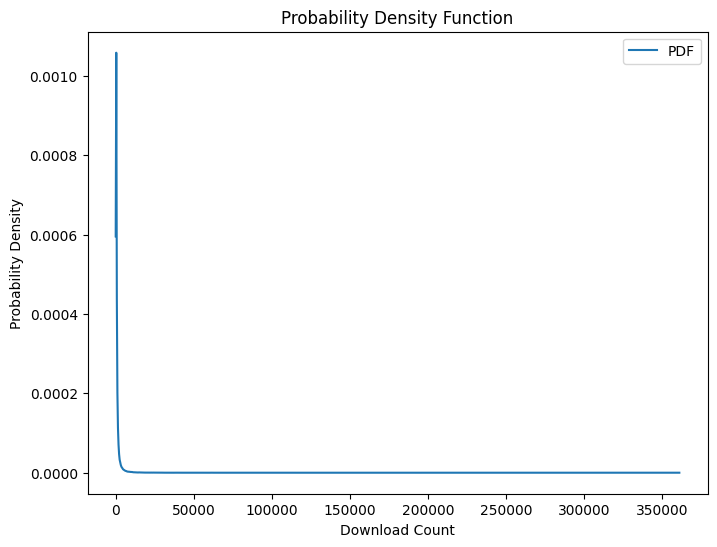

In [27]:
# Convert the list to a pandas Series
data = pd.Series(lora_download_count)

# # Plot the histogram of the data
# plt.hist(data, bins=100, density=True, alpha=0.7, label='Data Histogram')

# ecdf = ECDF(data)
# xmin, xmax = min(data), max(data)
# x = np.linspace(xmin, xmax, 100)
# plt.step(ecdf.x, ecdf.y, label='Empirical CDF')
# plt.show()

# Kernel Density Estimation for the PDF
kde = gaussian_kde(data)
kde.set_bandwidth(bw_method=kde.factor / 3.)

# Creating a range of values for which we will plot the PDF
x_range = np.linspace(min(data), max(data), 1000)

# Calculating the PDF values for each point in the x_range
pdf_values = kde.evaluate(x_range)

# Plotting the PDF
plt.figure(figsize=(8, 6))
plt.plot(x_range, pdf_values, label='PDF')
plt.title('Probability Density Function')
plt.xlabel('Download Count')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Calculating best minimal value for power law fit
2.2297772671765115 1189.0 0.009242266669293784
Loglikelihood ratio (R) comparing power law and lognormal distributions: -56.186672135576174
Statistical significance of R: 9.112979738491262e-10
Calculating best minimal value for power law fit
Kolmogorov-Smirnov test comparing power law and empirical data: 0.01647661366464126


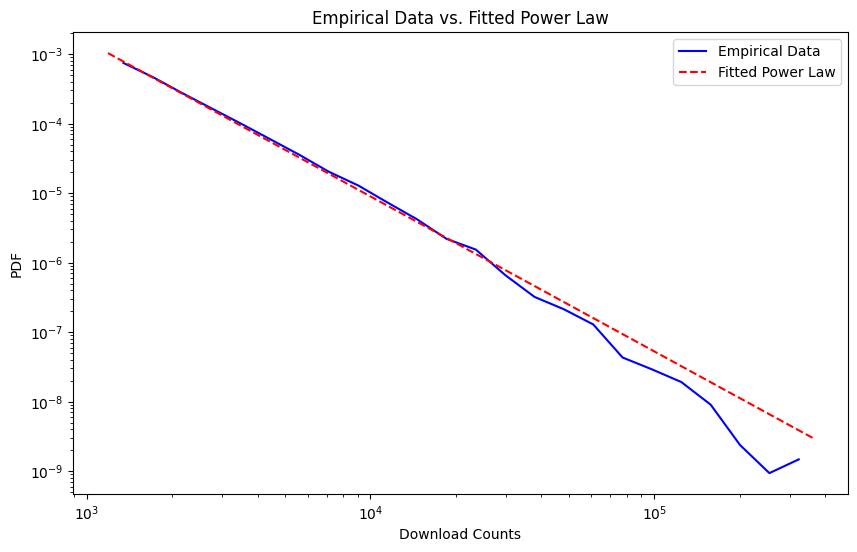

In [40]:
# Fit the data to a power-law distribution
fit = powerlaw.Fit(lora_download_count, discrete=True)
# Note: Consider specifying `xmin` based on empirical analysis or fit diagnostics
print(fit.power_law.alpha, fit.power_law.xmin, fit.power_law.sigma)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot the empirical data
empirical_data = fit.plot_pdf(color='b', linestyle='-', label='Empirical Data')

# Plot the fitted power-law distribution
power_law = fit.power_law.plot_pdf(color='r', linestyle='--', label='Fitted Power Law')

# Assuming fit is your powerlaw.Fit object
R, p = fit.distribution_compare('power_law', 'lognormal')

print("Loglikelihood ratio (R) comparing power law and lognormal distributions:", R)
print("Statistical significance of R:", p)

KSfit = powerlaw.Fit(lora_download_count, discrete=True, fit_method='KS')
print("Kolmogorov-Smirnov test comparing power law and empirical data:", KSfit.power_law.D)

plt.xlabel('Download Counts')
plt.ylabel('PDF')
plt.title('Empirical Data vs. Fitted Power Law')
plt.legend()

# Set log-log scale to better visualize power-law behavior
plt.xscale('log')
plt.yscale('log')

plt.show()

In [41]:
# List of distributions to check
distributions = [
    "norm", "expon", "lognorm", "gamma", "beta",
    "weibull_min", "weibull_max", "pareto", "genextreme"
]

# Store results here
results = []

# Kolmogorov-Smirnov test for each distribution
for distribution in distributions:
    dist = getattr(stats, distribution)
    param = dist.fit(data)
    print(f"Fitting {distribution} distribution with parameters: {param}")
    D, p_value = stats.kstest(data, distribution, args=param)
    results.append((distribution, D, p_value))

# Sort by p-value
results.sort(key=lambda x: x[1])

# Print results
print("Distribution tests results:")
for result in results:
    print(f"{result[0]:15}: D = {result[1]:.7f}")

# The distribution with the highest p-value is considered the best fit.

Fitting norm distribution with parameters: (1040.7662355277819, 3866.615464275024)
Fitting expon distribution with parameters: (3.0, 1037.7662355277819)
Fitting lognorm distribution with parameters: (1.1846748345933968, 1.911000793467772, 424.3634943979548)
Fitting gamma distribution with parameters: (3.6016702704210333e-05, 2.9999999999999996, 4.27077146346602)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitting beta distribution with parameters: (0.6719083216276541, 2922.2396588718225, 2.9999999999999964, 4521284.773574628)
Fitting weibull_min distribution with parameters: (0.7192866658485757, 2.9999999999999996, 759.4212927418184)
Fitting weibull_max distribution with parameters: (0.06542859339462817, 361000.0000000001, 1.7587483804804989)
Fitting pareto distribution with parameters: (2.23863008527221, -1138.2096990637174, 1141.2096990637172)
Fitting genextreme distribution with parameters: (-3.88223568586863, 5.925575621888118, 11.364498497218243)
Distribution tests results:
lognorm        : D = 0.0331467
pareto         : D = 0.0759338
weibull_min    : D = 0.1146688
beta           : D = 0.1528985
expon          : D = 0.2086939
norm           : D = 0.3942792
genextreme     : D = 0.5939004
weibull_max    : D = 0.8889228
gamma          : D = 0.9999412


Parameters: (1.1846748345933968, 1.911000793467772, 424.3634943979548)
Kolmogorov-Smirnov statistic: 0.033146696549469445


/var/folders/k8/sz_zxs1s5vsb7t8zh62jzj5w0000gn/T/ipykernel_63637/2686403858.py:25: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, pdf_fitted, 'r-', linestyle='--', label='Lognorm PDF')


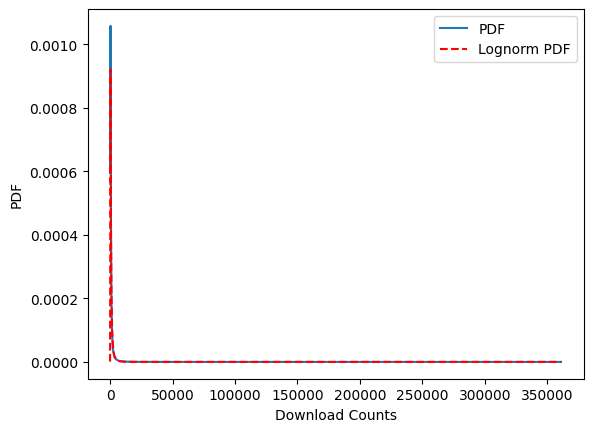

In [12]:
# Lognormal distribution

distribution = stats.lognorm  # replace with your chosen distribution
params = distribution.fit(data)
print(f"Parameters: {params}")

# Generate a range of values over which to evaluate the CDF
xmin, xmax = min(data), max(data)
x = np.linspace(xmin, xmax, 1000)

# Calculate the PDF of the fitted distribution
pdf_fitted = distribution.pdf(x, *params)

# Calculate the loss
D, _ = stats.kstest(data, 'lognorm', args=params)
print(f"Kolmogorov-Smirnov statistic: {D}")

# Plot the PDF of the original data
pdf_values = kde.evaluate(x)
plt.plot(x, pdf_values, label='PDF')

# Plot the CDF of the fitted distribution
plt.plot(x, pdf_fitted, 'r-', linestyle='--', label='Lognorm PDF')

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('Download Counts')
plt.ylabel('PDF')
plt.legend()
plt.show()

Parameters: (2.23863008527221, -1138.2096990637174, 1141.2096990637172)
Kolmogorov-Smirnov test: D = 0.0759338


/var/folders/k8/sz_zxs1s5vsb7t8zh62jzj5w0000gn/T/ipykernel_63637/105232527.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Pareto PDF')


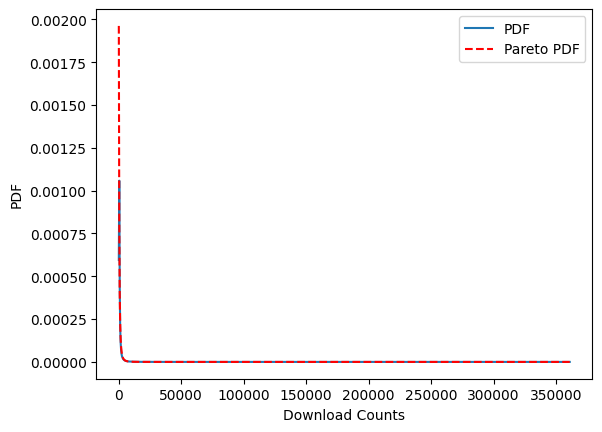

In [14]:
# Pareto distribution
distribution = stats.pareto
params = distribution.fit(data)
print(f"Parameters: {params}")

# Generate a range of values over which to evaluate the CDF
xmin, xmax = min(data), max(data)
x = np.linspace(xmin, xmax, 1000)

# Calculate the PDF of the fitted distribution
cdf_fitted = distribution.pdf(x, *params)

# Calculate the loss
D, _ = stats.kstest(data, 'pareto', args=params)
print(f"Kolmogorov-Smirnov test: D = {D:.7f}")

# Plot the PDF of the original data
pdf_values = kde.evaluate(x)
plt.plot(x, pdf_values, label='PDF')

# Plot the CDF of the fitted distribution
plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Pareto PDF')

plt.xlabel('Download Counts')
plt.ylabel('PDF')
plt.legend()
plt.show()


Parameters: (0.7192866658485757, 2.9999999999999996, 759.4212927418184)
Kolmogorov-Smirnov test: D = 0.1146688


/var/folders/k8/sz_zxs1s5vsb7t8zh62jzj5w0000gn/T/ipykernel_63637/3829858069.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Weibull Min PDF')


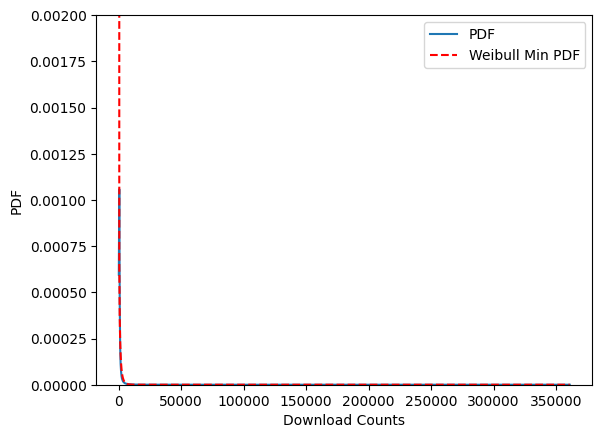

In [20]:
# Weibull minimum distribution
distribution = stats.weibull_min
params = distribution.fit(data)
print(f"Parameters: {params}")

# Generate a range of values over which to evaluate the CDF
xmin, xmax = min(data), max(data)
x = np.linspace(xmin, xmax, 1000)

# Calculate the PDF of the fitted distribution
cdf_fitted = distribution.pdf(x, *params)

# Calculate the loss
D, _ = stats.kstest(data, 'weibull_min', args=params)
print(f"Kolmogorov-Smirnov test: D = {D:.7f}")

# Plot the PDF of the original data
pdf_values = kde.evaluate(x)
plt.plot(x, pdf_values, label='PDF')

plt.ylim(0, 0.002)

# Plot the CDF of the fitted distribution
plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Weibull Min PDF')

plt.xlabel('Download Counts')
plt.ylabel('PDF')
plt.legend()
plt.show()

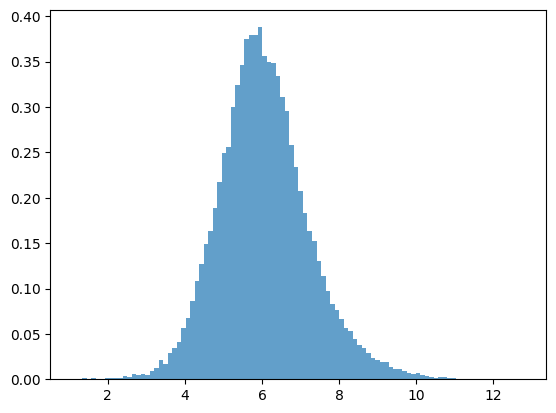

In [342]:
# Plot the histogram of log(data)
plt.hist(np.log(data), bins=100, density=True, alpha=0.7, label='Data Histogram')
plt.show()

Estimated parameters: shape (sigma) = 1.174902182654867, loc = 0, scale (exp(mu)) = 428.044317020051
Kolmogorov-Smirnov test comparing log-normal and empirical data: 0.033730196552252845


/var/folders/k8/sz_zxs1s5vsb7t8zh62jzj5w0000gn/T/ipykernel_63637/1863128604.py:31: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(points, pdf, 'r-', lw=2, linestyle='--', label='Fitted log-normal PDF')


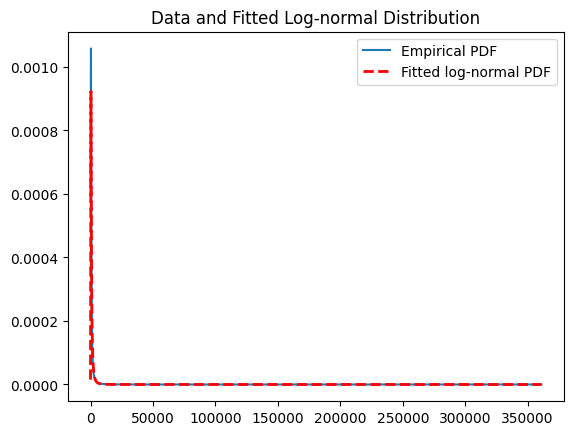

In [38]:
from scipy.stats import lognorm

data = lora_download_count

# Fit a log-normal distribution to this data
shape, loc, scale = lognorm.fit(data, floc=0)


print(f"Estimated parameters: shape (sigma) = {shape}, loc = {loc}, scale (exp(mu)) = {scale}")

# To visualize the fit, you can plot the PDF alongside your data
import matplotlib.pyplot as plt

# Generate points on the x axis:
points = np.linspace(min(data), max(data), 1000)

# Calculate the PDF of the fitted log-normal distribution:
pdf = lognorm.pdf(points, shape, loc=loc, scale=scale)

# Calculate the KS statistic between the empirical data and the fitted log-normal distribution
KS = stats.kstest(data, 'lognorm', args=(shape, loc, scale)).statistic
print("Kolmogorov-Smirnov test comparing log-normal and empirical data:", KS)

# Plot the PDF of the empirical data
plt.plot(points, pdf_values, label='Empirical PDF')

# Plot the PDF of the fitted log-normal distribution
plt.plot(points, pdf, 'r-', lw=2, linestyle='--', label='Fitted log-normal PDF')

plt.legend()
plt.title('Data and Fitted Log-normal Distribution')
plt.show()

Parameters: (0.1481080274106454, 2.9999999999999996, 360997.00000000006)
Kolmogorov-Smirnov test: D = 0.4512698


/var/folders/k8/sz_zxs1s5vsb7t8zh62jzj5w0000gn/T/ipykernel_63637/3518341943.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Power-law PDF')


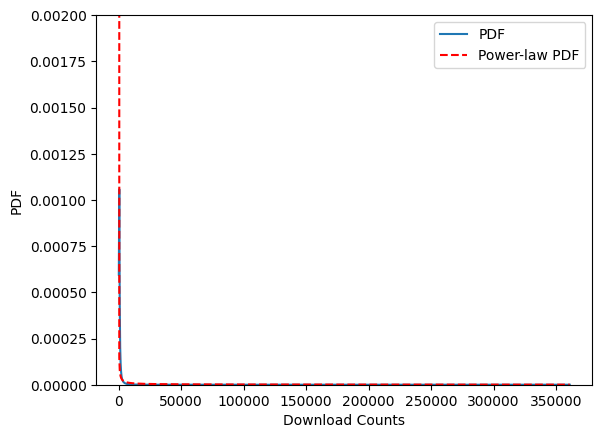

In [21]:
# Power-law distribution
distribution = stats.powerlaw
params = distribution.fit(data)
print(f"Parameters: {params}")

# Generate a range of values over which to evaluate the CDF
xmin, xmax = min(data), max(data)
x = np.linspace(xmin, xmax, 1000)

# Calculate the PDF of the fitted distribution
cdf_fitted = distribution.pdf(x, *params)

# Calculate the loss
D, _ = stats.kstest(data, 'powerlaw', args=params)
print(f"Kolmogorov-Smirnov test: D = {D:.7f}")

# Plot the PDF of the original data
pdf_values = kde.evaluate(x)
plt.plot(x, pdf_values, label='PDF')

plt.ylim(0, 0.002)

# Plot the CDF of the fitted distribution
plt.plot(x, cdf_fitted, 'r-', linestyle='--', label='Power-law PDF')

plt.xlabel('Download Counts')
plt.ylabel('PDF')
plt.legend()
plt.show()
